In [1]:
import torch.nn as nn
import torch
import torchvision.transforms as transforms
import torchvision
import time
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
from sklearn.metrics import confusion_matrix
import pandas as pd
import os

In [2]:
def get_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images,_ in loader:
        images_count_in_batch = images.size(0)
#         print(images.shape)
        images =images.view(images_count_in_batch,images.size(1),-1)
        mean+=images.mean(2).sum(0)
        std+=images.std(2).sum(0)
        total_images_count+=images_count_in_batch
    mean /= total_images_count
    std /= total_images_count
    return mean,std

In [3]:
def transform(dataset):
    data_transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])
    data_set=torchvision.datasets.ImageFolder(root=dataset,transform=data_transform)
    data_loader=torch.utils.data.DataLoader(dataset=data_set,batch_size=32,shuffle=True)
    mean,std=get_mean_std(data_loader)
    data_transform = transforms.Compose([
        transforms.Resize((255,255)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])
    data_set=torchvision.datasets.ImageFolder(root=dataset,transform=data_transform)
    data_loader=torch.utils.data.DataLoader(dataset=data_set,batch_size=32,shuffle=True,drop_last=False,num_workers=0)
    return data_loader,data_set

In [4]:
train_dataset='../Datasets/dataset_2_classes/train/'
train_loader,training_dataset=transform(train_dataset)

In [6]:
def show_transformed_images(dataset):
    loader=torch.utils.data.DataLoader(dataset, batch_size=12,shuffle=True)
    batch=next(iter(loader))
    images, labels=batch
    
    grid=torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid,(1,2,0)))
    print('labels: ',labels)

In [7]:
show_transformed_images(training_dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1])


In [5]:
validate_dataset='../Datasets/dataset_2_classes/validate/'
validate_loader,validating_dataset=transform(validate_dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1])


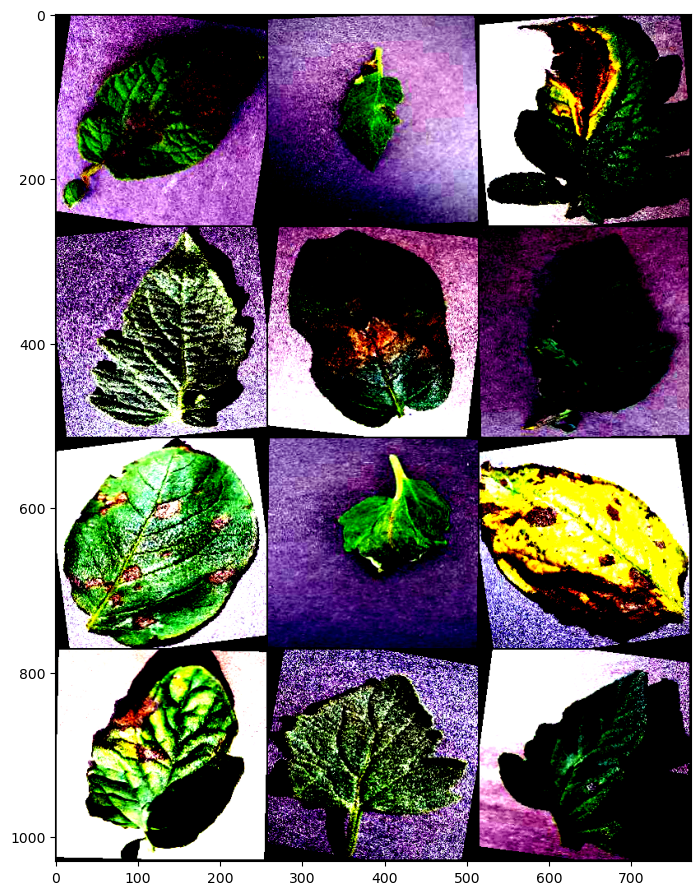

In [ ]:
show_transformed_images(validating_dataset)

In [6]:
test_dataset='../Datasets/dataset_2_classes/test/'
test_loader,testing_dataset=transform(test_dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


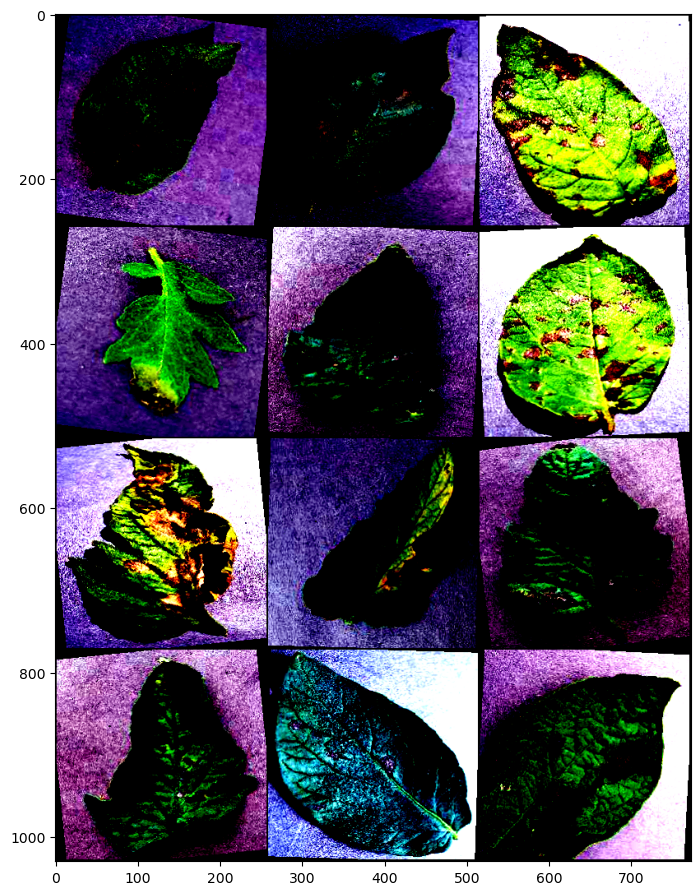

In [14]:
show_transformed_images(testing_dataset)

In [7]:
def set_device():
    device = "mps" if torch.backends.mps.is_available() else "cpu"
    return device

In [8]:
mobilenet=models.mobilenet_v2(pretrained=False, num_classes = 2)

/Users/bhanuprakash/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/bhanuprakash/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [10]:
count_parameters(mobilenet)

2226434

In [11]:
device=set_device()

In [12]:
mobilenet.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [13]:
print("Device: {}".format(device))

Device: mps


In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mobilenet.parameters(), lr=1e-3,momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0.0001)
n_epochs = 100
epoch_count = 0
Accuracies = [] 
valAccuracies = []
valLoss = []
trainLoss = []
total_steps = len(train_loader)
t1 = time.time()
validation_accuracy = 0

In [33]:
for epoch in range(n_epochs):
    print("Epoch: %d "%(epoch+1))
    mobilenet.train()
    running_loss=0.0
    running_correct=0.0
    val_loss=0.0
    total=0
    for i,data in enumerate(train_loader):
        images,labels=data
        images=images.to(device)
        labels=labels.to(device)
        total+=labels.size(0)
        optimizer.zero_grad()
        outputs=mobilenet(images)
        _,predicted=torch.max(outputs.data,1)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        running_correct+=(labels==predicted).sum().item()
        traning_accuracy=(running_correct/total)*100
    
    validation_accuracy=0
    mobilenet.eval()
    with torch.no_grad():
        val_correct=0
        val_total=0
        val_loss=0
        for data in validate_loader:
            images,val_labels=data[0].to(device), data[1].to(device)
            images = images.to(device)
            val_labels = val_labels.to(device)
            outputs=mobilenet(images)
            loss_val=criterion(outputs,val_labels)
            val_loss+= loss_val.item()
            _,predicted=torch.max(outputs.data,1)
            val_correct+=(predicted == val_labels).sum().item()
            val_total+=val_labels.size(0)
        validation_accuracy = (val_correct / val_total) *100
    
    scheduler.step()
    epoch_loss=running_loss/len(train_loader)
    val_loss=val_loss/len(validate_loader)
    epoch_accuracy=100.00* running_correct/total
    Accuracies.append(epoch_accuracy)
    valAccuracies.append(validation_accuracy)
    trainLoss.append(epoch_loss)
    valLoss.append(val_loss)
    
    print("Training Data: Epoch Loss: %.3f, Epoch Accuracy: %.3f, Validation Loss: %.3f,Validation Accuracy: %.3f"%(epoch_loss,epoch_accuracy,val_loss,validation_accuracy))
    
        

Epoch: 1 
Training Data: Epoch Loss: 0.035, Epoch Accuracy: 98.333, Validation Loss: 0.734,Validation Accuracy: 76.444
Epoch: 2 
Training Data: Epoch Loss: 0.039, Epoch Accuracy: 98.833, Validation Loss: 1.244,Validation Accuracy: 75.076
Epoch: 3 
Training Data: Epoch Loss: 0.034, Epoch Accuracy: 99.167, Validation Loss: 0.935,Validation Accuracy: 80.243
Epoch: 4 
Training Data: Epoch Loss: 0.064, Epoch Accuracy: 97.667, Validation Loss: 1.016,Validation Accuracy: 78.875
Epoch: 5 
Training Data: Epoch Loss: 0.054, Epoch Accuracy: 97.667, Validation Loss: 0.740,Validation Accuracy: 77.964
Epoch: 6 
Training Data: Epoch Loss: 0.035, Epoch Accuracy: 99.167, Validation Loss: 0.865,Validation Accuracy: 78.571
Epoch: 7 
Training Data: Epoch Loss: 0.037, Epoch Accuracy: 99.167, Validation Loss: 0.887,Validation Accuracy: 78.723
Epoch: 8 
Training Data: Epoch Loss: 0.034, Epoch Accuracy: 98.500, Validation Loss: 1.127,Validation Accuracy: 79.787
Epoch: 9 
Training Data: Epoch Loss: 0.017, Epoc

Training Data: Epoch Loss: 0.006, Epoch Accuracy: 100.000, Validation Loss: 0.917,Validation Accuracy: 80.547
Epoch: 71 
Training Data: Epoch Loss: 0.003, Epoch Accuracy: 100.000, Validation Loss: 0.872,Validation Accuracy: 81.763
Epoch: 72 
Training Data: Epoch Loss: 0.006, Epoch Accuracy: 99.833, Validation Loss: 0.952,Validation Accuracy: 81.003
Epoch: 73 
Training Data: Epoch Loss: 0.006, Epoch Accuracy: 100.000, Validation Loss: 0.843,Validation Accuracy: 82.523
Epoch: 74 
Training Data: Epoch Loss: 0.010, Epoch Accuracy: 100.000, Validation Loss: 0.952,Validation Accuracy: 81.915
Epoch: 75 
Training Data: Epoch Loss: 0.017, Epoch Accuracy: 99.333, Validation Loss: 0.960,Validation Accuracy: 82.219
Epoch: 76 
Training Data: Epoch Loss: 0.009, Epoch Accuracy: 99.500, Validation Loss: 0.952,Validation Accuracy: 80.091
Epoch: 77 
Training Data: Epoch Loss: 0.010, Epoch Accuracy: 99.833, Validation Loss: 1.214,Validation Accuracy: 80.699
Epoch: 78 
Training Data: Epoch Loss: 0.015, Ep

In [35]:
print("---Training finished in {} seconds---".format(time.time()-t1))
epoch_count+=n_epochs
torch.save(mobilenet.state_dict(), "2-Class-Mobilenetv2-"+str(epoch_count)+"-epoch.pt")

---Training finished in 1042.6119339466095 seconds---


In [36]:
def evaluate_model(model,test_loader):
    model.eval()
    predicted_correct =0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images,labels = data
            images = images.to(device)
            labels = labels.to(device)
            total+=labels.size(0)
            outputs = model(images)
            _,predicted = torch.max(outputs,1)
            predicted_correct += (predicted == labels).sum().item()
    epoch_accuracy = 100.0* predicted_correct/total
    print("Testing Data: Epoch Accuracy: %.3f"%(epoch_accuracy))
    return epoch_accuracy

In [37]:
test_acc = evaluate_model(mobilenet,test_loader)

Testing Data: Epoch Accuracy: 83.789


Test Accuracy of the model on the 1024 test images: 83.69140625 %


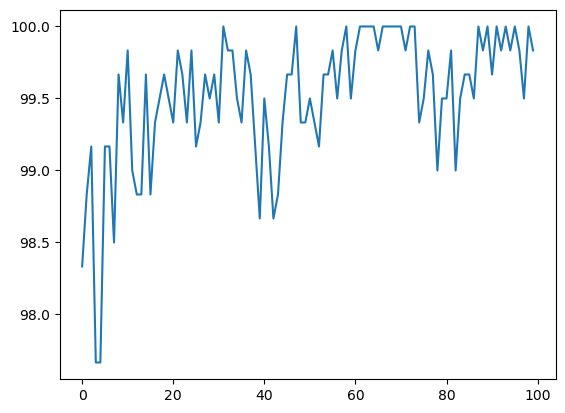

In [38]:
mobilenet.eval() 
perds = []
target = []
with torch.no_grad(): 
    correct = 0
    total = 0
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = mobilenet(images)
        _, predicted = torch.max(outputs.data, 1)
        perds.extend(predicted)
        target.extend(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the {} test images: {} %'
        .format(total, (correct / total) * 100))
    
plt.plot(Accuracies)

In [39]:
print(val_loss/len(validate_loader))

0.052758925051645894


In [40]:
dict = {'Training': Accuracies, 'Validation': valAccuracies} 
dictLoss = {'Training': trainLoss,'Validation': valLoss}
df = pd.DataFrame(dict)
df2 = pd.DataFrame(dictLoss)
df.to_csv("Accuracies_MobileNet_2classes"+str(epoch_count)+".csv")
df2.to_csv("Loss_Mobilenet_2classes"+str(epoch_count)+".csv")

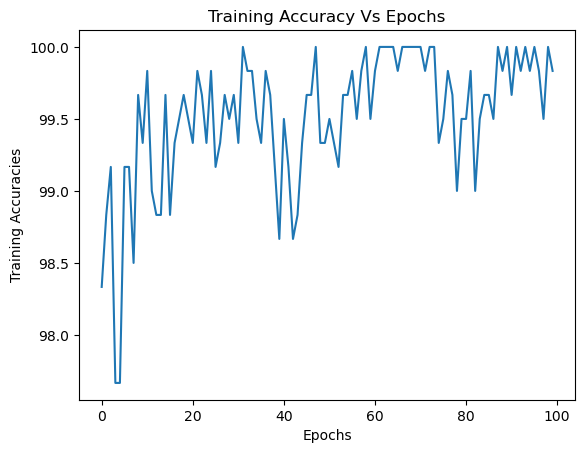

In [41]:
plt.plot(range(n_epochs),Accuracies)
plt.xlabel("Epochs")
plt.ylabel("Training Accuracies")
plt.title("Training Accuracy Vs Epochs")
plt.show()

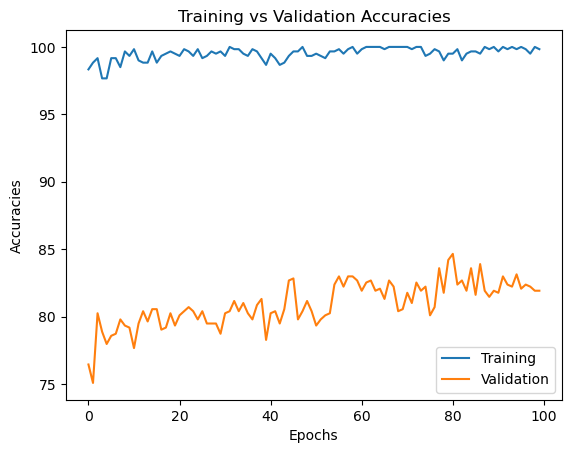

In [42]:
plt.plot(range(n_epochs),Accuracies, label="Training")
plt.plot(range(n_epochs),valAccuracies, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.title("Training vs Validation Accuracies")
plt.legend()
plt.show()

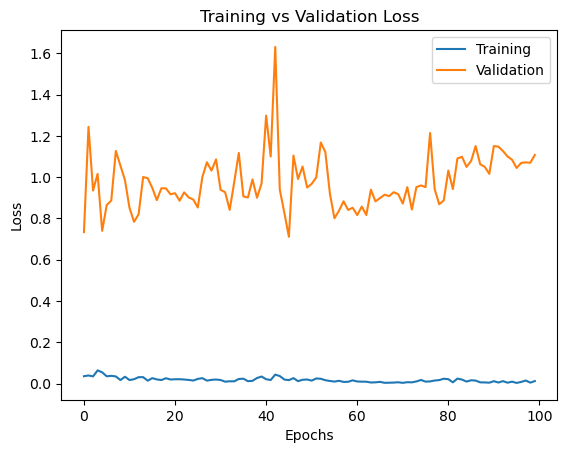

In [43]:
plt.plot(range(n_epochs),trainLoss, label="Training")
plt.plot(range(n_epochs),valLoss, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

In [44]:
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,ConfusionMatrixDisplay

In [45]:
y_pred = []
y_true = []

for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        output = mobilenet(inputs) 
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) 
        labels = labels.data.cpu().numpy()
        y_true.extend(labels)

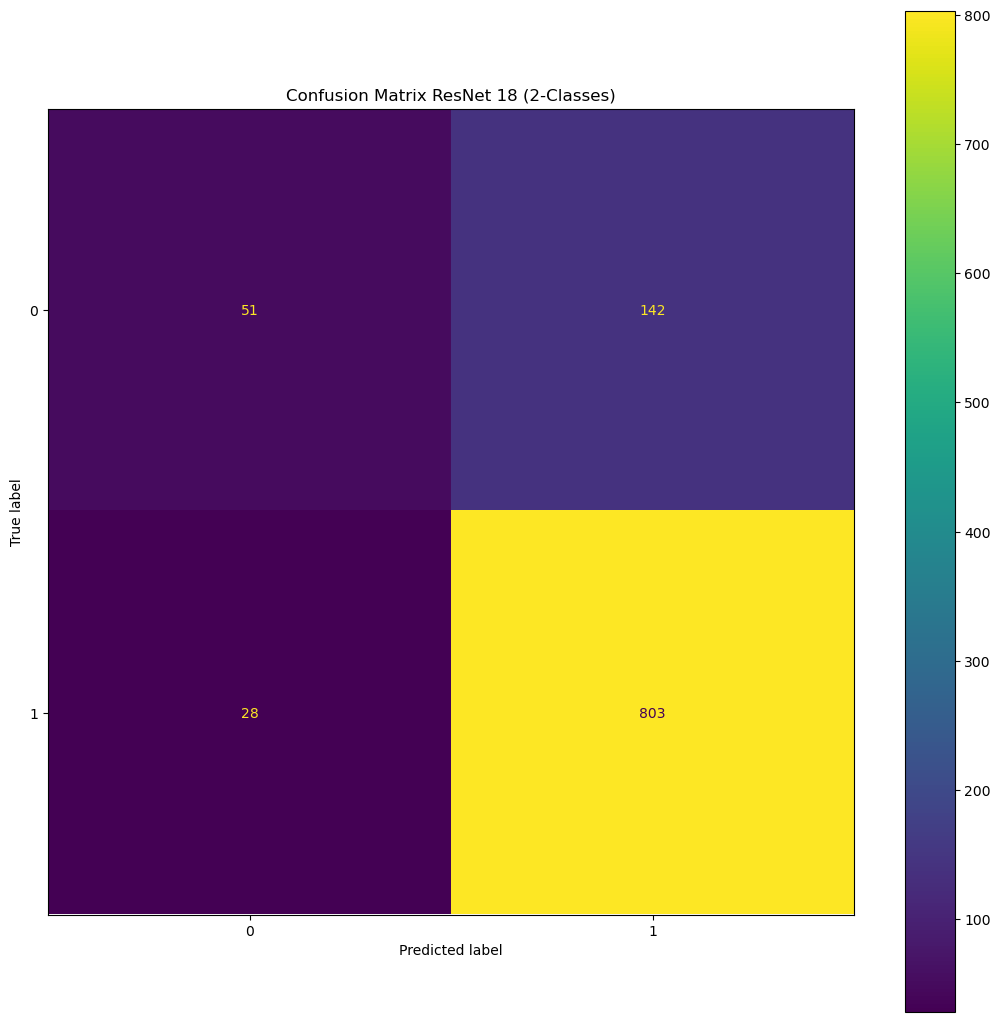

In [46]:
classes = (0,1)
confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred),display_labels=classes)
fig,ax = plt.subplots()
fig.set_size_inches(13,13)
plt.title("Confusion Matrix ResNet 18 (2-Classes)")
disp.plot(ax=ax)
plt.show()

In [47]:
print("Precision Macro:{:.2f}".format(precision_score(y_true, y_pred, average='macro')))
print("Precision Micro:{:.2f}".format(precision_score(y_true,y_pred,average='micro')))
print("Recall Macro:{:.2f}".format(recall_score(y_true,y_pred,average='macro')))
print("Recall Micro:{:.2f}".format(recall_score(y_true,y_pred,average='micro')))
print("F1-Score Macro:{:.2f}".format(f1_score(y_true,y_pred,average='macro')))
print("F1-Score Micro:{:.2f}".format(f1_score(y_true,y_pred,average='micro')))

Precision Macro:0.75
Precision Micro:0.83
Recall Macro:0.62
Recall Micro:0.83
F1-Score Macro:0.64
F1-Score Micro:0.83
